In [1]:
using SparseArrays, Plots, BenchmarkTools
include("../code/matrix_generator.jl")

valid_degrees (generic function with 2 methods)

In [2]:
function leaf_removal(H::SparseMatrixCSC, Ht = sparse(H'); randomize=false)
    M, N = size(H)
    degs = vec(sum(H, dims=1))
    facts = trues(M)
    rowperm = Int32[]
    Q = Int32.(findall(degs .== 1))
    indep = Int32.(findall(degs .== 0))
    dep = Int32[]
    sizehint!(indep, N-M)
    sizehint!(dep, M)
    sizehint!(rowperm, M)
    while !isempty(Q)
        if randomize
            L = length(Q)
            if L > 1
                r = rand(2:L)
                Q[1], Q[r] = Q[r], Q[1]
            end
        end
        i = popfirst!(Q)
        degs[i] == 0 && continue
        push!(dep, i)
        ∂i = @view rowvals(H)[nzrange(H,i)]
        a = ∂i[findfirst(b->facts[b], ∂i)]
        facts[a] = false
        push!(rowperm, a) 
        for j in @view rowvals(Ht)[nzrange(Ht,a)]
            degs[j] -= 1
            if j != i
                if degs[j] == 0
                    push!(indep, j)
                elseif degs[j] == 1
                    push!(Q, j)
                end
            end
        end
    end
    all(degs .==  0) || @warn "non-empty core"
    rowperm, dep, indep
end

leaf_removal (generic function with 2 methods)

In [3]:
function degree2_mat(N, f1=0.0)
    N1 = Int(N*f1)
    Q = mod1(sum(digits(2N-N1)),3)
    N1 = N1 + Q
    N2 = N - N1
    nedges = (N1+2N2)
    M = Int(nedges/3)
    Lambda = [N1, N2] / N
    @assert sum(Lambda)==1
    Rho = [0,0,1]
    Ht = ldpc_matrix(Int32(N), Int32(M), nedges, Lambda, Rho, accept_multi_edges=true)
    typeof(Ht)(Ht'), Ht
end

degree2_mat (generic function with 2 methods)

In [4]:
N=10^6
H,Ht = degree2_mat(Int32(N));

In [127]:
@btime leaf_removal($H,$Ht)

  383.130 ms (55 allocations: 32.29 MiB)


(Int32[634552, 172319, 37841, 590950, 256631, 366923, 190475, 653631, 193041, 237006  …  99964, 141461, 62293, 322419, 581347, 659269, 380481, 173786, 301917, 107640], Int32[287262, 364869, 876191, 531927, 889087, 606727, 674073, 672795, 64971, 431632  …  203328, 377032, 993825, 418902, 523863, 374370, 225827, 402650, 442973, 929894], Int32[778035, 784779, 519715, 109706, 227678, 982744, 47992, 66315, 127166, 467961  …  160993, 933277, 146735, 414473, 343770, 592417, 105012, 393270, 46159, 571895])

In [7]:
isuppertriang(H::SparseMatrixCSC) = all(rowvals(H)[last(nzrange(H,i))] == i for i = 1:size(H,1))

isuppertriang (generic function with 1 method)

In [4]:
function ut2diagGF2(Tdep, Tindep_t)
    m = size(Tdep,1)
    @assert isuppertriang(Tdep)
    # Store the rows of the right part in a vector of sparse vectors
#     Tt = permutedims(Tindep)
    R = [Tindep_t[:,r] for r in 1:m]
    # Loop over diagonal elements
    @inbounds for c in m:-1:2
        # Loop over the elements above T[c,c]
        for j in @view rowvals(Tdep)[nzrange(Tdep,c)[1:end-1]]
            R[j] .⊻= R[c]
        end
    end
    #U = reduce(hcat,R)
    R
end

ut2diagGF2 (generic function with 1 method)

In [6]:
function ut2diagGF2(Hdep, Hindep, rowperm)
    m = length(rowperm)
    invrowperm = invperm(rowperm)
#     @assert isuppertriang(H,rowperm,invrowperm)
    # Store the rows of the right part in a vector of sparse vectors
    Hindep_t = permutedims(Hindep)
    R = [Hindep_t[:,r] for r in rowperm]
#     rows = @view invrowperm[rowvals(Hdep)]
    # Loop over diagonal elements
    @inbounds for c in m:-1:2
        # Loop over the elements above T[c,c]
        for j in @view invrowperm[rowvals(Hdep)[nzrange(Hdep,c)]]
#         for j in rows[nzrange(Hdep,c)]
            j!=c && (R[j] .⊻= R[c])
        end
    end
    #U = reduce(hcat,R)
    R
end

ut2diagGF2 (generic function with 1 method)

In [7]:
function echelonize(H, Ht, rowperm, colperm)
    m = size(H,1)
    # @assert isuppertriang(H[rowperm, colperm])
    # Store the rows of the right part in a vector of sparse vectors
    R = [Ht[:,r] for r in 1:m]
    # Loop over diagonal elements
    for c in m:-1:2
        # Loop over the elements above T[c,c]
        for j in @view rowvals(H)[nzrange(H,colperm[c])]
            if j ≠ rowperm[c]
                R[j] .⊻= R[rowperm[c]]
            end
        end
    end
    R
end

echelonize (generic function with 1 method)

In [5]:
function echelonize(Hdep, Hindep_t)
    m = size(Hdep,1)
    @assert isuppertriang(Hdep)
    # Store the rows of the right part in a vector of sparse vectors
    R = [Hindep_t[:,r] for r in 1:m]
    # Loop over diagonal elements
    @inbounds for c in m:-1:2
        # Loop over the elements above H[c,c]
        for j in @view rowvals(Hdep)[nzrange(Hdep,c)[1:end-1]]
            R[j] .⊻= R[c]
        end
    end
    R
end
function echelonize_approx(H, Ht, rowperm, colperm)
    m = size(H,1)
    # @assert isuppertriang(H[rowperm, colperm])
    # Store the rows of the right part in a vector of sparse vectors
    R = [Int.(Ht[:,r]) for r in 1:m]
    # Loop over diagonal elements
    for c in m:-1:2
        # Loop over the elements above T[c,c]
        for j in @view rowvals(H)[nzrange(H,colperm[c])]
            if j ≠ rowperm[c]
                R[j] .+= R[rowperm[c]]
            end
        end
    end
    R
end
function echelonize_quick(Hdep, Hindep_t)
    m = size(Hdep,1)
    @assert isuppertriang(Hdep)
    h = vec(sum(Hindep_t,dims=1))
    # Loop over diagonal elements
    @inbounds for c in m:-1:2
        # Loop over the elements above H[c,c]
        for j in @view rowvals(Hdep)[nzrange(Hdep,c)[1:end-1]]
            h[j] += h[c]
        end
    end
    h
end

echelonize_quick (generic function with 1 method)

In [11]:
N = 10^7
@time H,Ht = degree2_mat(Int32(N))
@time rowperm, dep, indep = leaf_removal(H,Ht, randomize=true)
@time Hdep, Htindep = H[rowperm,dep], Ht[indep,rowperm]
@time h = echelonize_quick(Hdep, Htindep);

  7.859172 seconds (58 allocations: 765.326 MiB, 1.85% gc time)
  4.562604 seconds (58 allocations: 193.758 MiB, 1.70% gc time)
  9.927965 seconds (43 allocations: 511.807 MiB, 0.35% gc time)
  0.257806 seconds (6 allocations: 50.863 MiB)


In [37]:
N = 10^8
@time H,Ht = degree2_mat(Int32(N))
@time rowperm, dep, indep = leaf_removal(H,Ht) 
@time Hdep, Htindep = H[rowperm,dep], Ht[indep,rowperm]
@time R = echelonize(Hdep, Htindep);

164.612507 seconds (58 allocations: 7.474 GiB, 3.67% gc time)
 60.806206 seconds (60 allocations: 1.785 GiB)
159.525219 seconds (43 allocations: 4.998 GiB, 0.28% gc time)
860.932472 seconds (395.09 M allocations: 40.232 GiB, 92.87% gc time)


In [244]:
N = 10^7
H,Ht = degree2_mat(Int32(N), 0.0)
rowperm, dep, indep = leaf_removal(H,Ht)
R1 = echelonize(H,Ht,rowperm,dep);
R2 = echelonize_approx(H,Ht,rowperm,dep);
htrue = sum.(R1)
happrox = sum.(R2);

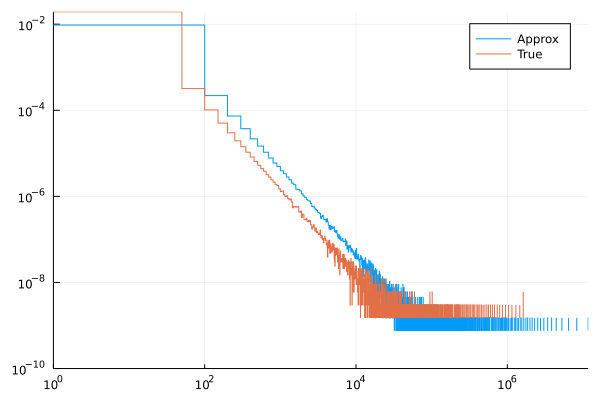

In [245]:
h1 = histogram(happrox, label="Approx", xlims=(0,10^5), normalize=true, bins=20*10^4, 
    yaxis=(:log10,(1e-10,Inf)), xaxis=(:log10,(1,Inf)))
histogram!(h1, htrue, label="True", xlims=(0,10^5), normalize=true, bins=4*10^4, 
    yaxis=(:log10,(1e-10,Inf)), xaxis=(:log10,(1,Inf)))
# h2 = histogram(htrue, label="True", xlims=(0,10^5), normalize=true, bins=4*10^4, 
#     yaxis=(:log10,(1e-10,Inf)), xaxis=(:log10,(1,Inf)))
# println("Horizontal weights. N=",N)
# plot(h1,h2, size=(800,300))

In [121]:
function test1(H,Ht)
    rowperm, dep, indep = leaf_removal(H, Ht)
    Tdep, Tindep = H[rowperm,dep], H[rowperm,indep]
    ut2diagGF2(Tdep, Tindep)
end

function test2(H,Ht)
    rowperm, dep, indep = leaf_removal(H, Ht)
    Hdep, Hindep = H[:,dep], H[:,indep]
    ut2diagGF2(Hdep, Hindep, rowperm)
end

function test3(H,Ht)
    rowperm, dep, indep = leaf_removal(H, Ht)
    colperm = [dep; indep]
    echelonize(H, Ht, rowperm, colperm)
end

test3 (generic function with 1 method)

In [138]:
N = 10^4
H,Ht = degree2_mat(Int32(N));
# R1 = test1(H,Ht)
# R2 = test2(H,Ht)
# R1 == R2

In [142]:
rowperm, dep, indep = leaf_removal(H, Ht)
R = echelonize(H, Ht, rowperm, dep)
U = reduce(hcat,R)
U[[dep;indep],rowperm]

10000×6666 SparseMatrixCSC{Bool, Int32} with 82053 stored entries:
⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀
⣶⣶⣶⣶⣶⣶⣶⣦⣤⣄⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠃
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⣄⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⡿⡿⣿⣿⣿⣿⣿⣿⡿⣿

In [123]:
@btime test1($H,$Ht);

  1.853 s (3950850 allocations: 471.76 MiB)


In [124]:
@btime test2($H,$Ht);

  1.564 s (4617491 allocations: 493.37 MiB)


In [125]:
@btime test3($H,$Ht);

  1.790 s (3855311 allocations: 427.00 MiB)


Build graphs of increasing size with $f_2=1$

In [130]:
Ns = round.(Int, 10^5 * (1:10:101))
times_old = zeros(length(Ns))
times_new = zeros(length(Ns))
for (i,N) in pairs(Ns)
    println("## Size $i of ", length(Ns), ": N=$N")
    H, Ht = degree2_mat(N)
    t = @timed test3(H,Ht)
    times_new[i] = t[2]
end

## Size 1 of 11: N=100000
## Size 2 of 11: N=1100000
## Size 3 of 11: N=2100000
## Size 4 of 11: N=3100000
## Size 5 of 11: N=4100000
## Size 6 of 11: N=5100000
## Size 7 of 11: N=6100000
## Size 8 of 11: N=7100000
## Size 9 of 11: N=8100000
## Size 10 of 11: N=9100000
## Size 11 of 11: N=10100000


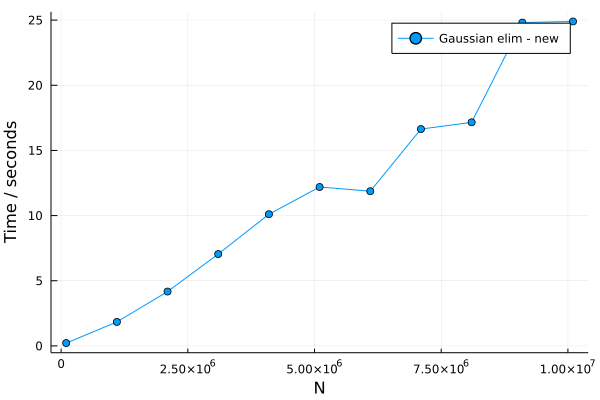

In [131]:
#p1 = plot(Ns, times_old, marker=:circle, label="Gaussian elim - old", xlabel="N", ylabel="Time / seconds")
p2 = plot(Ns, times_new, marker=:circle, label="Gaussian elim - new", xlabel="N", ylabel="Time / seconds")
#plot(p1,p2, size=(1000,400), margins=10Plots.mm)

In [144]:
N=10^7
@time H,Ht = degree2_mat(Int32(N));

 15.145808 seconds (53 allocations: 765.326 MiB, 2.59% gc time)


In [145]:
@time rowperm, dep, indep = leaf_removal(H, Ht)
@time echelonize(H, Ht, rowperm, dep);

  7.059996 seconds (62 allocations: 310.772 MiB)
 17.488394 seconds (38.56 M allocations: 3.986 GiB, 20.57% gc time)


The complete function to build a basis is
`[1] findbasis(H) in Main at /home/crotti/sourcecoding/code/slim_graphs.jl:120`